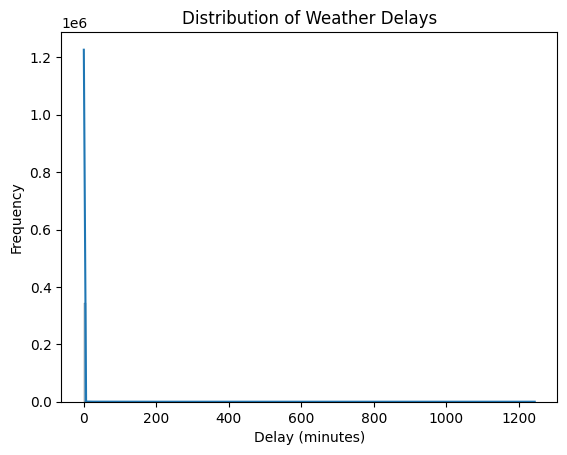

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pyfiglet

# Reading data
data = pd.read_csv("tnst_matched.csv")

# Building distribution & scoring delays
mu = np.mean(data["weather_delay"])
sigma = np.std(data["weather_delay"])
data["weather_z_score"] = (data["weather_delay"] - mu) / sigma

# Visualizing distribution
sns.histplot(data["weather_delay"], kde=True, bins=194)
plt.title("Distribution of Weather Delays")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

In [11]:
# Calculating Linear Correlation between features and weather_delay
feature_data = data.drop(columns=["date", "icao", "weather_delay", "weather_z_score"])
correlations = feature_data.corrwith(data["weather_delay"], method="pearson")
print("Linear Correlation (Features Correlation to Weather_Delay)")
print(correlations)

# Calculating Spearman Correlation between features and weather_delay (do both increase together/monotonic relationships)
feature_data = data.drop(columns=["date", "icao", "weather_delay", "weather_z_score"])
correlations = feature_data.corrwith(data["weather_delay"], method="spearman")
print("Spearman Correlation (Features Correlation to Weather_Delay)")
print(correlations)

# Calculating Kendall Correlation between features and weather_delay (do both increase together/monotonic relationships)(better for smaller sample sizes)
feature_data = data.drop(columns=["date", "icao", "weather_delay", "weather_z_score"])
correlations = feature_data.corrwith(data["weather_delay"], method="kendall")
print("Kendall Correlation (Features Correlation to Weather_Delay)")
print(correlations)

Linear Correlation (Features Correlation to Weather_Delay)
congestion_score   -0.000576
wind_dir            0.007359
wind_speed          0.017870
ceiling            -0.018137
visibility         -0.038552
temp               -0.004427
dew_pnt             0.003891
pressure           -0.015332
dtype: float64
Spearman Correlation (Features Correlation to Weather_Delay)
congestion_score   -0.015233
wind_dir            0.016927
wind_speed          0.031190
ceiling            -0.043503
visibility         -0.051674
temp                0.008176
dew_pnt             0.027952
pressure           -0.036359
dtype: float64
Kendall Correlation (Features Correlation to Weather_Delay)
congestion_score   -0.012801
wind_dir            0.014024
wind_speed          0.026716
ceiling            -0.037746
visibility         -0.049814
temp                0.006712
dew_pnt             0.022971
pressure           -0.029687
dtype: float64


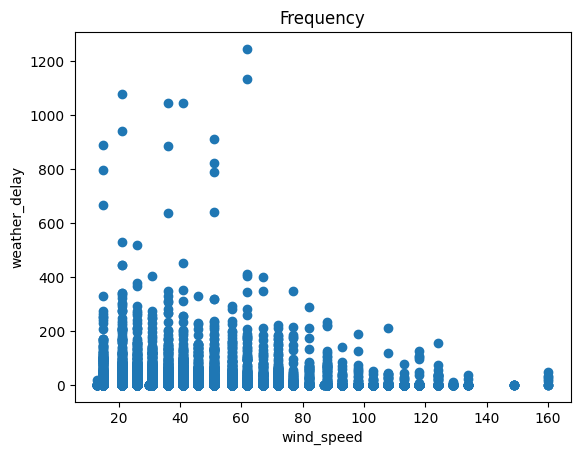

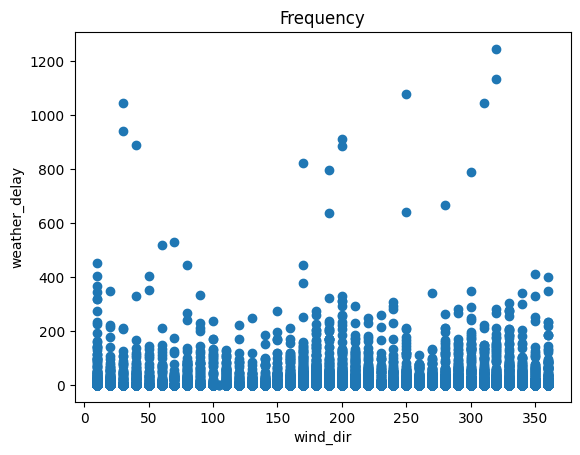

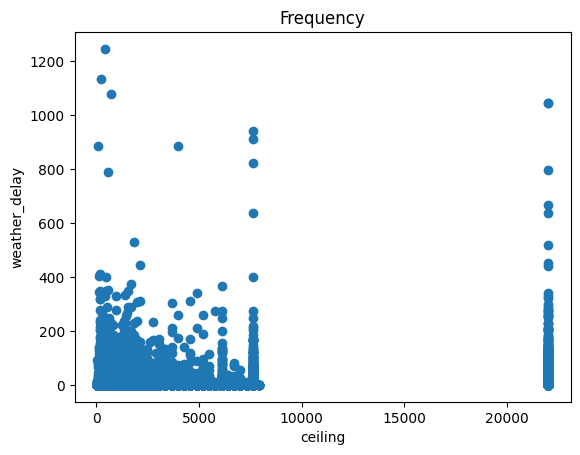

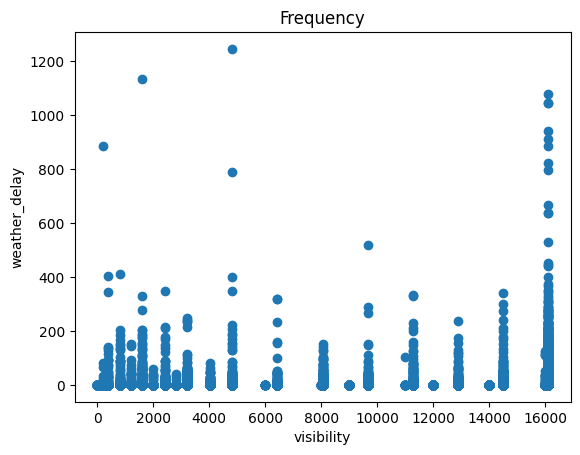

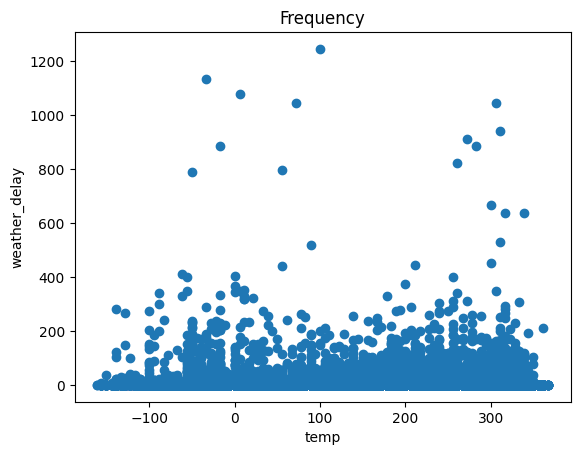

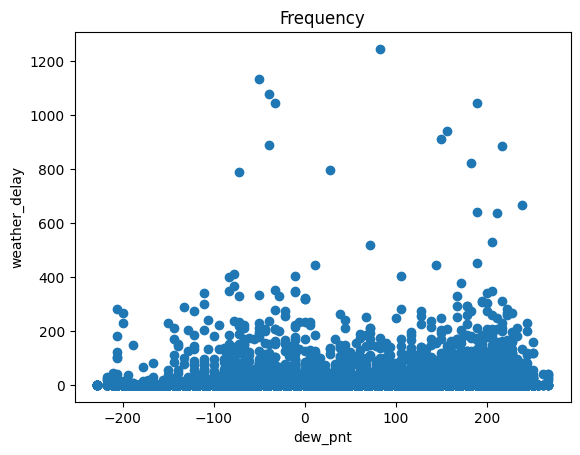

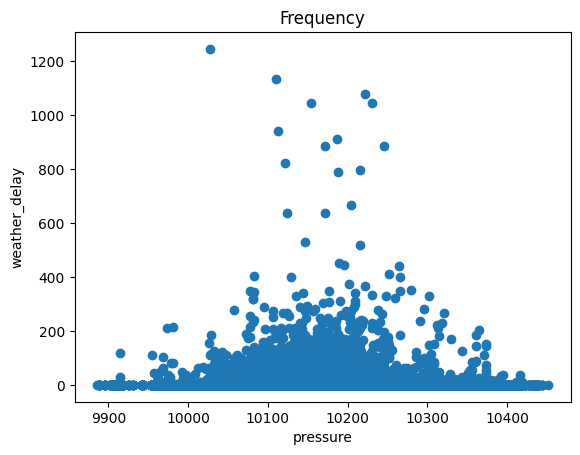

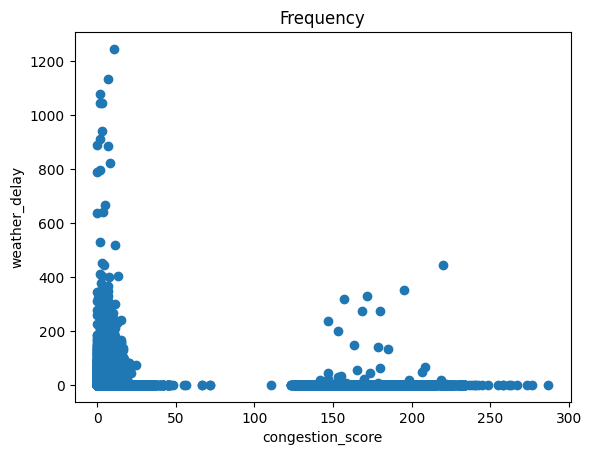

In [16]:
# Graphing features against wind delay

# wind_speed
plt.scatter(data["wind_speed"], data["weather_delay"])
plt.xlabel("wind_speed")
plt.ylabel("weather_delay")
plt.title("Frequency")
plt.show()

# wind_dir
plt.scatter(data["wind_dir"], data["weather_delay"])
plt.xlabel("wind_dir")
plt.ylabel("weather_delay")
plt.title("Frequency")
plt.show()

# ceiling
plt.scatter(data["ceiling"], data["weather_delay"])
plt.xlabel("ceiling")
plt.ylabel("weather_delay")
plt.title("Frequency")
plt.show()

# visibility
plt.scatter(data["visibility"], data["weather_delay"])
plt.xlabel("visibility")
plt.ylabel("weather_delay")
plt.title("Frequency")
plt.show()

# temp
plt.scatter(data["temp"], data["weather_delay"])
plt.xlabel("temp")
plt.ylabel("weather_delay")
plt.title("Frequency")
plt.show()

# dew_pnt
plt.scatter(data["dew_pnt"], data["weather_delay"])
plt.xlabel("dew_pnt")
plt.ylabel("weather_delay")
plt.title("Frequency")
plt.show()

# pressure
plt.scatter(data["pressure"], data["weather_delay"])
plt.xlabel("pressure")
plt.ylabel("weather_delay")
plt.title("Frequency")
plt.show()

# congestion_score
plt.scatter(data["congestion_score"], data["weather_delay"])
plt.xlabel("congestion_score")
plt.ylabel("weather_delay")
plt.title("Frequency")
plt.show()

Model Performance:
  R² Score: -0.0253
  MAE: 0.93 minutes
  RMSE: 8.95 minutes

Feature Importance:
         feature  importance
congestion_score    0.272495
        wind_dir    0.183162
      wind_speed    0.117150
      visibility    0.095949
         dew_pnt    0.089017
            temp    0.083462
        pressure    0.081929
         ceiling    0.076836


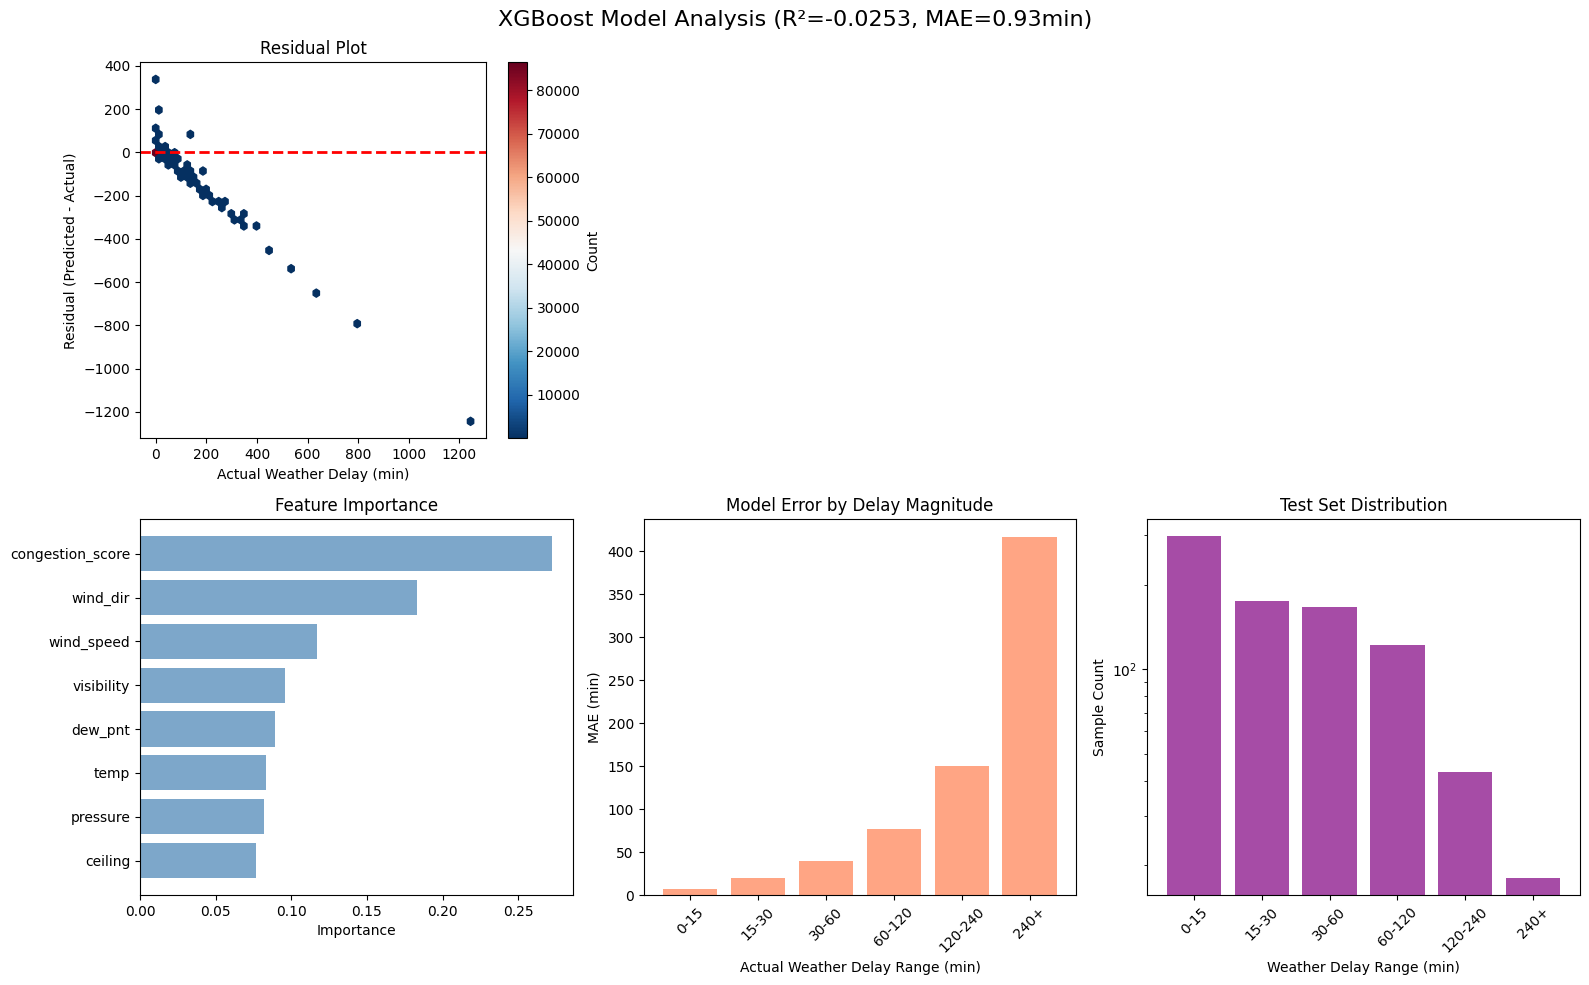

In [18]:
# Creating features and targets
X = data[["wind_dir", "wind_speed", "ceiling", "visibility", "temp", "dew_pnt", "pressure", "congestion_score"]]
y = data["weather_delay"]

# Splitting into train test batches
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Building XGBoost Model
model = XGBRegressor(
    n_estimators=1000,
    max_depth=4,
    learning_rate=0.1,
    random_state=42  # Add for reproducibility
)

# Training and testing model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate multiple metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Performance:")
print(f"  R² Score: {r2:.4f}")
print(f"  MAE: {mae:.2f} minutes")
print(f"  RMSE: {rmse:.2f} minutes")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print(feature_importance.to_string(index=False))

# Calculate residuals
residuals = y_pred - y_test

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 10))

# Plot 1: Residual plot
ax1 = plt.subplot(2, 3, 1)
plt.hexbin(y_test, residuals, gridsize=50, cmap='RdBu_r', mincnt=1)
plt.colorbar(label='Count')
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel("Actual Weather Delay (min)")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residual Plot")

# Plot 2: Feature Importance
ax4 = plt.subplot(2, 3, 4)
plt.barh(feature_importance['feature'], feature_importance['importance'], color='steelblue', alpha=0.7)
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.gca().invert_yaxis()

# Plot 3: Performance by delay magnitude
ax5 = plt.subplot(2, 3, 5)
bins = [0, 15, 30, 60, 120, 240, np.inf]
bin_labels = ['0-15', '15-30', '30-60', '60-120', '120-240', '240+']
weather_delay_bins = pd.cut(y_test, bins=bins, labels=bin_labels)

bin_mae = []
bin_counts = []
for bin_label in bin_labels:
    mask = weather_delay_bins == bin_label
    if mask.sum() > 0:
        bin_mae.append(mean_absolute_error(y_test[mask], y_pred[mask]))
        bin_counts.append(mask.sum())
    else:
        bin_mae.append(0)
        bin_counts.append(0)

plt.bar(bin_labels, bin_mae, color='coral', alpha=0.7)
plt.xlabel("Actual Weather Delay Range (min)")
plt.ylabel("MAE (min)")
plt.title("Model Error by Delay Magnitude")
plt.xticks(rotation=45)

# Plot 6: Sample distribution
ax6 = plt.subplot(2, 3, 6)
plt.bar(bin_labels, bin_counts, color='purple', alpha=0.7)
plt.xlabel("Weather Delay Range (min)")
plt.ylabel("Sample Count")
plt.title("Test Set Distribution")
plt.xticks(rotation=45)
plt.yscale('log')

plt.suptitle(f'XGBoost Model Analysis (R²={r2:.4f}, MAE={mae:.2f}min)', fontsize=16)
plt.tight_layout()
plt.show()

### Results Explanation:
##### The data consisted of around 1000 data points for KBNA (ICAO code), or Nashville International Airport (2015-2016) for weather delays. Input data consisted of temperature, dewpoint, pressure, wind speed, wind gusts, visibility, and cloud ceiling (METAR data). The output being predicted is the expected delay (in minutes) caused by the given weather conditions. Additionally to this we also used all the data to develop a normal distribution curve which allows us to then give meaning to the output from our model. To interpret the models output we can simply take the z-score of the given weather prediction and calculate the area on the left half to obtain information on how severe the weather conditions are

#### Why normal build normal distribution?:
##### By building a normal distribution and rating weather severity score based off that we allow the data to decide what is extreme weather, without having to introduce our own personal bias.
